In [1]:
from rational.utils.convert_network import convert_mxnet_model_to_rational
from rational.utils.examples.mxnet import prepare_data_mxnet, train_model_mxnet

import mxnet
from mxnet import gpu
from mxnet.gluon.nn import Flatten, Dense
from mxnet.gluon.model_zoo import vision

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')

In [2]:
seed = 4242
mxnet.random.seed(seed)
np.random.seed(seed)

In [3]:
device = gpu(3)
epochs = 10

train_data, test_data = prepare_data_mxnet(batch_size=256)

In [4]:
vgg = vision.vgg11(pretrained=False)

# modify for mnist
vgg.features = vgg.features[:21]
vgg = vgg.features
vgg.add(Flatten())
vgg.add(Dense(10))

In [5]:
rational_model = convert_mxnet_model_to_rational(vgg, rational_device=device)
rational_model.initialize(ctx=device)
vgg.initialize(ctx=device)

In [6]:
relu_history = train_model_mxnet(vgg, train_data, test_data, device=device, epochs=epochs)

[Epoch   1] train_acc: 65.73% - train_loss:  1.135
[Epoch   1] val_acc: 87.66% - val_loss:  0.340
Model runtime: 26.968s
[Epoch   2] train_acc: 92.73% - train_loss:  0.229
[Epoch   2] val_acc: 90.70% - val_loss:  0.265
Model runtime: 51.549s
[Epoch   3] train_acc: 95.22% - train_loss:  0.151
[Epoch   3] val_acc: 96.11% - val_loss:  0.118
Model runtime: 75.987s
[Epoch   4] train_acc: 96.25% - train_loss:  0.117
[Epoch   4] val_acc: 97.07% - val_loss:  0.085
Model runtime: 100.268s
[Epoch   5] train_acc: 97.06% - train_loss:  0.095
[Epoch   5] val_acc: 97.75% - val_loss:  0.065
Model runtime: 124.883s
[Epoch   6] train_acc: 97.37% - train_loss:  0.083
[Epoch   6] val_acc: 97.82% - val_loss:  0.063
Model runtime: 149.293s
[Epoch   7] train_acc: 97.65% - train_loss:  0.074
[Epoch   7] val_acc: 98.35% - val_loss:  0.047
Model runtime: 173.800s
[Epoch   8] train_acc: 97.93% - train_loss:  0.065
[Epoch   8] val_acc: 97.73% - val_loss:  0.069
Model runtime: 198.195s
[Epoch   9] train_acc: 98.0

In [7]:
rational_history = train_model_mxnet(rational_model, train_data, test_data, device=device, epochs=epochs)

[Epoch   1] train_acc: 69.65% - train_loss:  0.960
[Epoch   1] val_acc: 95.26% - val_loss:  0.142
Model runtime: 38.290s
[Epoch   2] train_acc: 95.68% - train_loss:  0.139
[Epoch   2] val_acc: 97.85% - val_loss:  0.065
Model runtime: 76.595s
[Epoch   3] train_acc: 97.14% - train_loss:  0.091
[Epoch   3] val_acc: 96.99% - val_loss:  0.091
Model runtime: 114.791s
[Epoch   4] train_acc: 97.81% - train_loss:  0.069
[Epoch   4] val_acc: 97.78% - val_loss:  0.066
Model runtime: 153.082s
[Epoch   5] train_acc: 98.18% - train_loss:  0.058
[Epoch   5] val_acc: 98.81% - val_loss:  0.036
Model runtime: 191.195s
[Epoch   6] train_acc: 98.45% - train_loss:  0.049
[Epoch   6] val_acc: 98.71% - val_loss:  0.039
Model runtime: 230.023s
[Epoch   7] train_acc: 98.62% - train_loss:  0.043
[Epoch   7] val_acc: 98.85% - val_loss:  0.035
Model runtime: 268.656s
[Epoch   8] train_acc: 98.85% - train_loss:  0.037
[Epoch   8] val_acc: 98.66% - val_loss:  0.041
Model runtime: 307.096s
[Epoch   9] train_acc: 98.

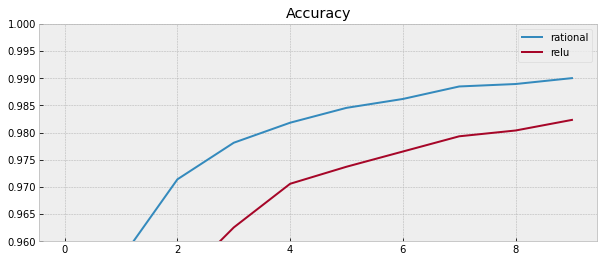

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['accuracy'], label='rational')
plt.plot(range(epochs), relu_history['accuracy'], label='relu')
plt.title('Accuracy')
plt.ylim((0.96, 1))
plt.legend()
plt.show()

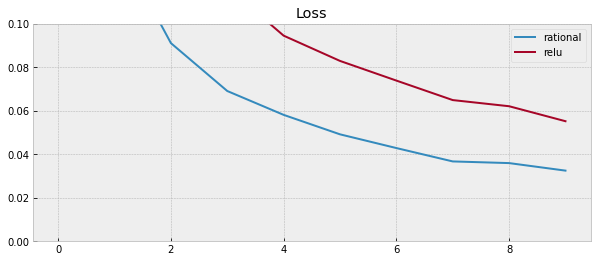

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['loss'], label='rational')
plt.plot(range(epochs), relu_history['loss'], label='relu')
plt.title('Loss')
plt.ylim((0, 0.1))
plt.legend()
plt.show()

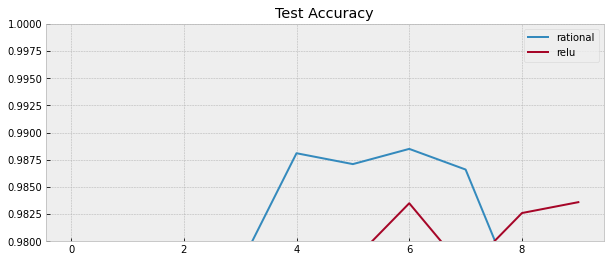

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['val_accuracy'], label='rational')
plt.plot(range(epochs), relu_history['val_accuracy'], label='relu')
plt.title('Test Accuracy')
plt.ylim((0.98, 1))
plt.legend()
plt.show()

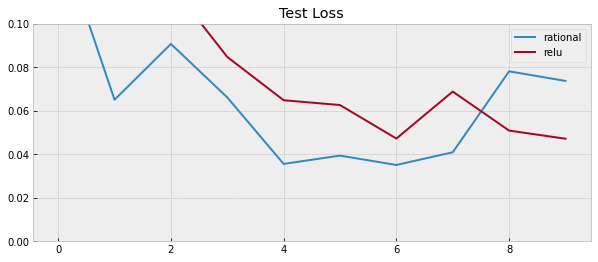

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(range(epochs), rational_history['val_loss'], label='rational')
plt.plot(range(epochs), relu_history['val_loss'], label='relu')
plt.title('Test Loss')
plt.ylim((0, 0.1))
plt.legend()
plt.show()